<a href="https://colab.research.google.com/github/radek2017/anomaly_detection/blob/master/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Anomaly Detection in Multivariate Time Series with Keras and LSTM** 

Based on power Consumption data from Denmark (DK) between 2013 and now available at:

https://www.nordpoolgroup.com/historical-market-data/

**Init environment**

In [0]:
%tensorflow_version 2.x
from IPython.display import display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
from joblib import load, dump
from warnings import filterwarnings
from datetime import datetime, time


# init libraries
def Init():
  
    pd.plotting.register_matplotlib_converters()
    filterwarnings(action='ignore', category=DataConversionWarning)
    sns.set(style='whitegrid', palette='muted', font_scale=1.6)  # plot style
    rcParams['figure.figsize'] = 16, 7  # plot size
    tf.random.set_seed(13)
    np.random.seed(13)


Init()


**Load all data from the Web or a saved cache file**

In [56]:
START_YEAR = 2013
LOAD_DATA_FROM_SAVED_FILE = False


# load Power Consumption data for Denmark (DK) between start_year and now from:
# https://www.nordpoolgroup.com/historical-market-data/
def LoadDataFromWeb(start_year=START_YEAR):

    converters = {0: (lambda s: datetime.strptime(s, '%d-%m-%Y').date()),
                  1: (lambda s: int(s[0:2])), 2: (lambda s: int(s)),
                  3: (lambda s: int(s)), 4: (lambda s: int(s))}
    list = []
    for year in range(start_year, datetime.now().year + 1):
        list.append(pd.read_html('https://www.nordpoolgroup.com/globalassets/' \
            'marketdata-excel-files/consumption-dk-areas_%s_hourly.xls' % year,
            header=2, converters=converters)[0])
    pd.concat(list).dropna().to_pickle('raw_data.gz')


if not LOAD_DATA_FROM_SAVED_FILE:
    LoadDataFromWeb()

data = pd.read_pickle('raw_data.gz')
display(data)


,Unnamed: 0,Hours,DK1,DK2,DK
0,2013-01-01,0,2018,1522,3540
1,2013-01-01,1,1948,1470,3418
2,2013-01-01,2,1795,1396,3191
3,2013-01-01,3,1732,1319,3051
4,2013-01-01,4,1667,1261,2928
...,...,...,...,...,...
1851,2020-03-18,3,1962,1208,3170
1852,2020-03-18,4,2021,1184,3205
1853,2020-03-18,5,2103,1266,3369
1854,2020-03-18,6,2402,1403,3805


**Add a Time (DateTime) column and show an all-time graph**

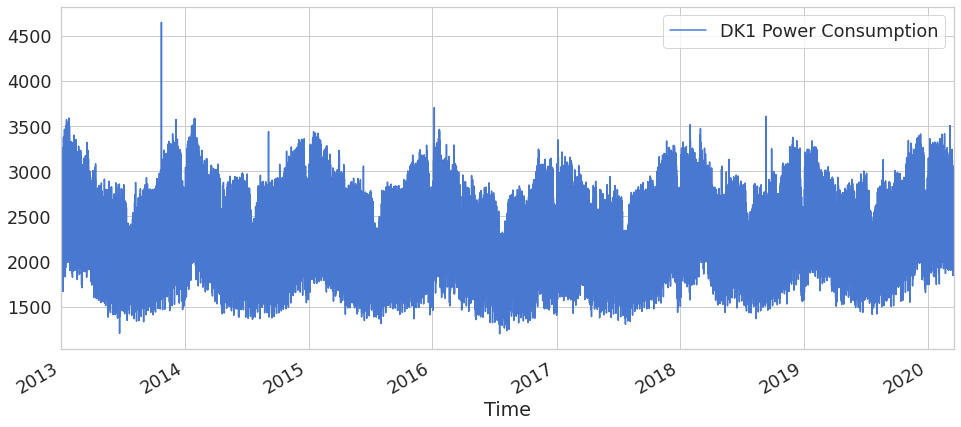

In [57]:
AREA = 'DK1'

# combine date and time
data.rename(columns={'Unnamed: 0': 'Date', 'Hours': 'Hour'}, inplace=True)
data.insert(0, 'Time', data[['Date', 'Hour']].
            apply(lambda row: datetime.combine(row['Date'], time(row['Hour'])), axis=1))

data.plot(x='Time', y=AREA, label=AREA + " Power Consumption")
plt.legend()
plt.show()


**Show a shorter graph**

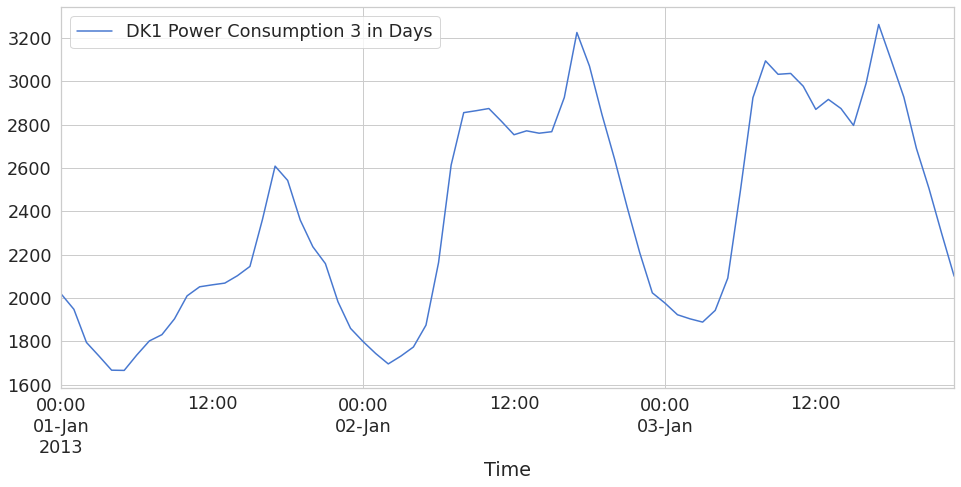

In [58]:
SHOW_DAYS = 3

data[0:(24 * SHOW_DAYS)].plot(x='Time', y=AREA, label=AREA +
                              " Power Consumption %s in Days" % SHOW_DAYS)
plt.legend()
plt.show()


**Show another shorter graph**

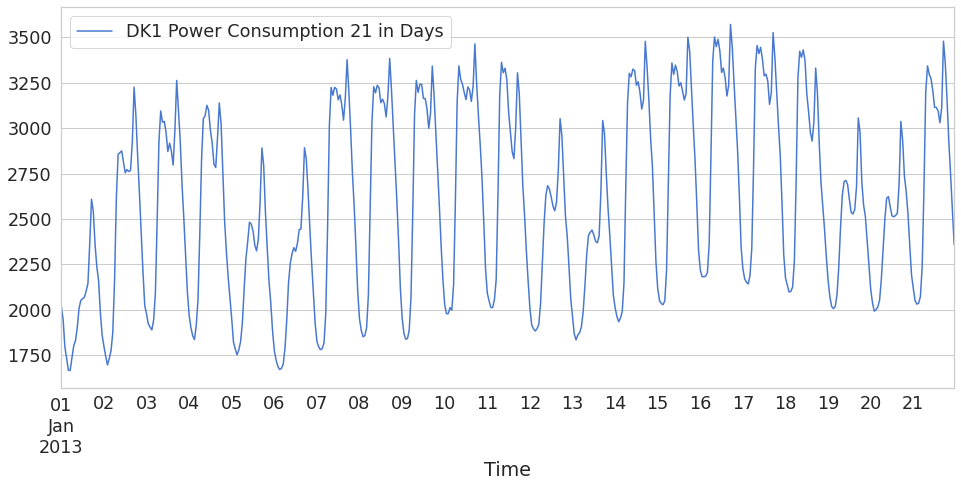

In [59]:
SHOW_DAYS = 3 * 7

data[0:(24 * SHOW_DAYS)].plot(x='Time', y=AREA, label=AREA +
                              " Power Consumption %s in Days" % SHOW_DAYS)
plt.legend()
plt.show()


**Add additional columns to train from and to make a multivariate time series**

In [60]:
# Danish holidays between 2013 and 2020 from https://da.wikipedia.org/wiki/Danske_helligdage
holidays = \
    [(0, 1, 1), (0, 6, 5), (0, 12, 24), (0, 12, 25), (0, 12, 26), (0, 12, 31),
     (2013, 3, 24), (2013, 3, 28), (2013, 3, 29), (2013, 3, 31), (2013, 4, 1),
     (2013, 4, 26), (2013, 5, 9), (2013, 5, 19), (2013, 5, 20),
     (2014, 4, 13), (2014, 4, 17), (2014, 4, 18), (2014, 4, 20), (2014, 4, 21),
     (2014, 5, 16), (2014, 5, 29), (2014, 6, 8), (2014, 6, 9),
     (2015, 3, 29), (2015, 4, 2), (2015, 4, 3), (2015, 4, 5), (2015, 4, 6),
     (2015, 5, 1), (2015, 5, 14), (2015, 5, 24), (2015, 5, 25),
     (2016, 3, 20), (2016, 3, 24), (2016, 3, 25), (2016, 3, 27), (2016, 3, 28),
     (2016, 4, 22), (2016, 5, 5), (2016, 5, 15), (2016, 5, 16),
     (2017, 4, 9), (2017, 4, 13), (2017, 4, 14), (2017, 4, 16), (2017, 4, 17),
     (2017, 5, 12), (2017, 5, 25), (2017, 6, 4), (2017, 6, 5),
     (2018, 3, 25), (2018, 3, 29), (2018, 3, 30), (2018, 4, 1), (2018, 4, 2),
     (2018, 4, 27), (2018, 5, 10), (2018, 5, 20), (2018, 5, 21),
     (2019, 4, 14), (2019, 4, 18), (2019, 4, 19), (2019, 4, 21), (2019, 4, 22),
     (2019, 5, 17), (2019, 5, 30), (2019, 6, 9), (2019, 6, 10),
     (2020, 4, 5), (2020, 4, 9), (2020, 4, 10), (2020, 4, 12), (2020, 4, 13),
     (2020, 5, 8), (2020, 5, 21), (2020, 5, 31), (2020, 6, 1)]


# check a date and return 0 for a Danish holiday, 1 for Monday, 2 for Tuesday, etc., 7 for Sunday
def WeekDay(date):

    for day in holidays:
        if (day[0] == 0 or day[0] == date.year) and day[1] == date.month and day[2] == date.day:
            return 0
    return date.isoweekday()


# add new columns which we are going to use in the training
data.insert(1, 'Year', data['Date'].apply(lambda d: d.year))
data.insert(2, 'Month', data['Date'].apply(lambda d: d.month))
data.insert(3, 'WeekDay', data['Date'].apply(WeekDay))
del data['Date']
data.to_pickle('final_data.gz')

display(data)


,Time,Year,Month,WeekDay,Hour,DK1,DK2,DK
0,2013-01-01 00:00:00,2013,1,0,0,2018,1522,3540
1,2013-01-01 01:00:00,2013,1,0,1,1948,1470,3418
2,2013-01-01 02:00:00,2013,1,0,2,1795,1396,3191
3,2013-01-01 03:00:00,2013,1,0,3,1732,1319,3051
4,2013-01-01 04:00:00,2013,1,0,4,1667,1261,2928
...,...,...,...,...,...,...,...,...
1851,2020-03-18 03:00:00,2020,3,3,3,1962,1208,3170
1852,2020-03-18 04:00:00,2020,3,3,4,2021,1184,3205
1853,2020-03-18 05:00:00,2020,3,3,5,2103,1266,3369
1854,2020-03-18 06:00:00,2020,3,3,6,2402,1403,3805


**Prepare data for training and for validation**

In [0]:
TRAIN_AREA = 'DK1'
TRAIN_ON_COLUMNS = [TRAIN_AREA, 'Year', 'Month', 'WeekDay', 'Hour']

# how much data is used for training and how much is left for validation
TRAIN_DATA_PERCENTAGE = 0.95

# how many preceding steps for each step are used to predict the future
PAST_STEP_COUNT = 4

# False: predict one future step, True: predict PAST_STEP_COUNT future steps
MULTISTEP_FUTURE = True

# how many steps from each future prediction are used for anomaly detection
ANOMALY_STEP_COUNT = PAST_STEP_COUNT

# arbitrary tolerance (0..1+) of differences between real and predicted steps
ANOMALY_TOLERANCE = 0.5

# arbitrary sensitivity (0..1) to peaks 1=max, or sensitivity to flats 0=max
ANOMALY_PEAK_SENSITIVITY = 0.75


# split data between the training and validation data
def SplitData(percentage=TRAIN_DATA_PERCENTAGE):

    data = pd.read_pickle('final_data.gz')
    train_size = int(len(data) * percentage)
    return data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()


# find out how to scale down all values closer to zero, so that the model
# would train faster and more reliably
def TrainAndSaveScaler(data):

    scaler = StandardScaler()
    scaler.fit(data)
    dump(scaler, 'scaler.gz')


def LoadScaler():
    return load('scaler.gz')


# scale data to train on step_count past steps and predict either
# a single future step or step_count future steps
def ScaleData(data, scaler, multistep_future=MULTISTEP_FUTURE, step_count=PAST_STEP_COUNT):

    data = scaler.transform(data)
    X, Y, n = [], [], step_count
    for i in range(len(data) - (n*2 if multistep_future and n > 1 else n)):

        # keep all columns to train on in the model input (multivariate time series)
        X.append(data[i:(i + n)])

        if multistep_future and n > 1:
            # only the first column in the model output (univariate time series)
            # for amore reliable training (we don't need to predict the other columns)        
            Y.append(data[(i + n):(i + n*2), 0])

        else:
            # only the first column in the model output (univariate time series)
            Y.append(data[(i + n), 0])

    return np.array(X), np.array(Y)


train_data, validation_data = SplitData()

TrainAndSaveScaler(train_data[TRAIN_ON_COLUMNS])

scaler = LoadScaler()

X_train, Y_train = ScaleData(train_data[TRAIN_ON_COLUMNS], scaler)


**Train and save the model**

In [0]:
EPOCH_COUNT = 300

SKIP_TRAINING_AND_LOAD_MODEL_FROM_SAVED_FILE = False


def TrainModel(X_data, Y_data, epoch_count):
    model = keras.Sequential()

    # many columns (multivariate) 3D input
    model.add(keras.layers.LSTM(units=64, input_shape=X_data.shape[-2:]))

    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_data.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    # only one column (univariate) 2D output (units=1)
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=1)))

    model.compile(loss='mae', optimizer='adam')

    train_history = model.fit(X_data, Y_data, epochs=epoch_count, batch_size=64,
                              validation_split=0.05, shuffle=False, verbose=2)
    return model, train_history


def TrainAndSaveModel(name, X_data, Y_data, epoch_count):
    model, train_history = TrainModel(X_data, Y_data, epoch_count)
    model.save(name + '.h5')
    dump(train_history.history, 'train_history.gz')


def LoadModel(name):
    return keras.models.load_model(name + '.h5')


if not SKIP_TRAINING_AND_LOAD_MODEL_FROM_SAVED_FILE:
    TrainAndSaveModel(TRAIN_ON_COLUMNS[0], X_train, Y_train, EPOCH_COUNT)


**Show training graph**

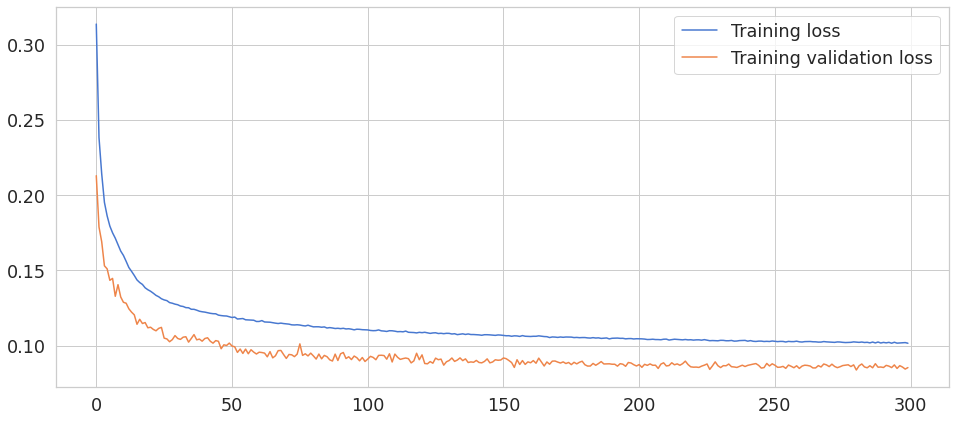

In [63]:
train_history = load('train_history.gz')

plt.plot(train_history['loss'], label='Training loss')
plt.plot(train_history['val_loss'], label='Training validation loss')
plt.legend()
plt.show()


**Predict training data and show the loss distribution**

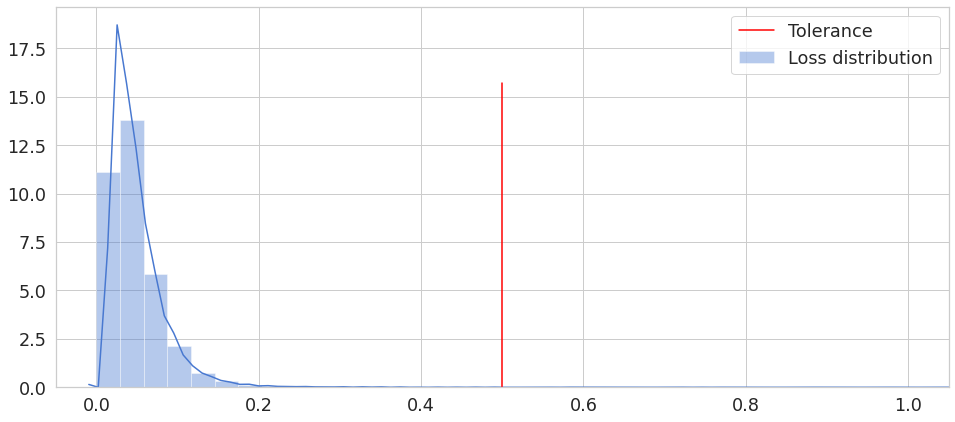

In [64]:
# difference between each step and its immediate predecessor to get more
# sensitivity to peaks (1=max) or flats (0=max)
def StepDifference(data, peak_sensitivity=1.0):

    result = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            result[i, j] -= (data[i, j - 1] if j > 0 else \
                             (data[i - 1, 0] if i > 0 else 0.0)) * peak_sensitivity
    return result


# average every 3 consecutive steps to compensate for horizontal fluctuations
# because of step quantization
def StepAverage(data):
  
    result = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            previous = data[i, j - 1] if j > 0 else \
                        (data[i - 1, 0] if i > 0 else data[i, j])
            next = data[i, j + 1] if j < data.shape[1] - 1 else 0.0
            result[i, j] = (previous + data[i, j] * 2 + next) / (4.0
                              if j < data.shape[1] - 1 else 3.0)
    return result


# predict future steps for each step in X_data, and calculate prediction loss
# from the first predicted steps
def PredictData(X_data, model, scaler, loss_step_count=ANOMALY_STEP_COUNT,
                peak_sensitivity=ANOMALY_PEAK_SENSITIVITY):
  
    # note: data right after prediction is 2D and lacks columns expected
    # by scaler.inverse_transform
    predicted = model.predict(X_data)

    # pad with zeroes in place of the missing columns to make it 3D and get
    # scaler.inverse_transform to work
    predicted = np.pad(predicted, ((0, 0), (0, 0), (0, X_data.shape[2] - 1)))

    # align predicted and real-life data by shifting real-life data to the left
    X = X_data[loss_step_count:, -loss_step_count:, 0]
    Y = predicted[:-loss_step_count, :loss_step_count, 0]

    # increase tolerance to fluctuations
    X = StepAverage(StepDifference(X, peak_sensitivity))
    Y = StepAverage(StepDifference(Y, peak_sensitivity))

    # calculate Root Mean Square Error
    loss = np.sqrt(np.mean((X - Y)**2, axis=1))

    # make both returned arrays - predicted and loss - have same length and size (1D)
    predicted = scaler.inverse_transform(predicted)[:, 0, 0]
    loss = np.pad(loss, (0, loss_step_count))
    return predicted, loss


def PlotLossDistribution(loss, tolerance=ANOMALY_TOLERANCE):
    sns.distplot(loss, bins=50, kde=True, label="Loss distribution")
    plt.xlim(-0.05, 1.05)
    plt.axvline(tolerance, 0, 0.8, color='red', label='Tolerance')
    plt.legend()
    plt.show()


model = LoadModel(TRAIN_ON_COLUMNS[0])
scaler = LoadScaler()

_, loss = PredictData(X_train, model, scaler)

PlotLossDistribution(loss)

**Predict all steps in the validation data and show prediction loss for each step**

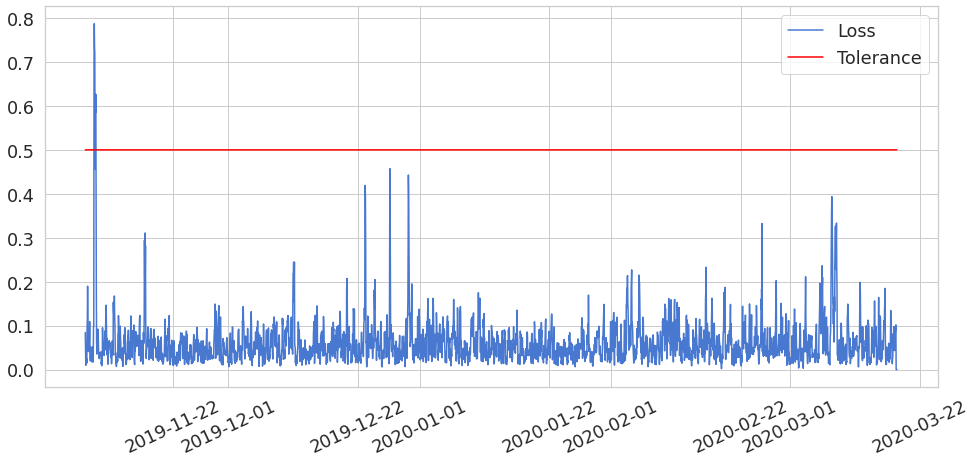

In [65]:
def PlotLoss(data, loss, tolerance=ANOMALY_TOLERANCE):
    score = pd.DataFrame(index=data.index)
    score['Loss'] = loss
    score['Tolerance'] = tolerance
    score['Anomaly'] = score['Loss'] > tolerance
    score['Time'] = data['Time']
    score[TRAIN_ON_COLUMNS[0]] = data[TRAIN_ON_COLUMNS[0]]

    plt.plot(score['Time'], score['Loss'], label='Loss')
    plt.plot(score['Time'], score['Tolerance'], color='red', label='Tolerance')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()

    return score[score['Anomaly'] == True]


X_data, _ = ScaleData(validation_data[TRAIN_ON_COLUMNS], scaler, False)
validation_data = validation_data[PAST_STEP_COUNT:]

predicted_data, loss = PredictData(X_data, model, scaler)

anomalies = PlotLoss(validation_data, loss)

**Show the actual and predicted validation data with anomalies**

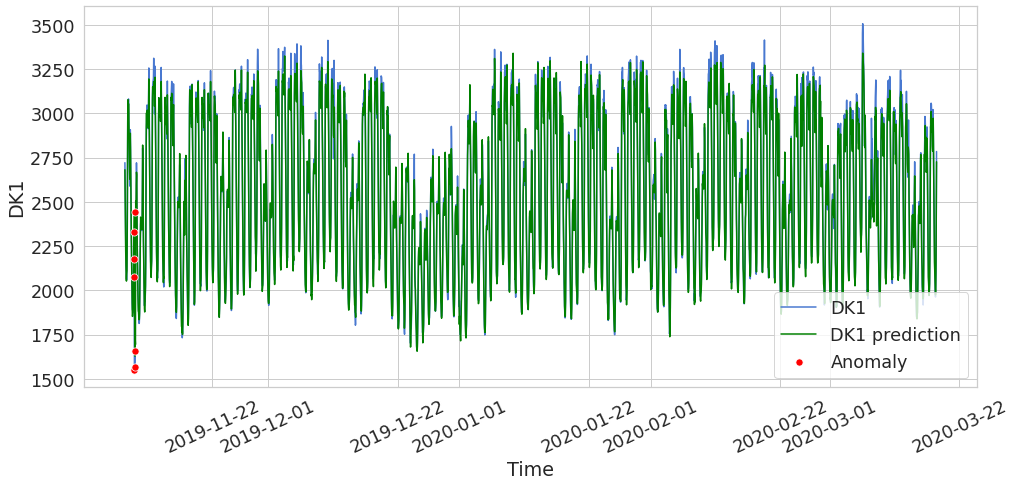

In [66]:
def PlotAnomalies(data, predicted_data, anomalies):
    column = TRAIN_ON_COLUMNS[0]
    plt.plot(data['Time'], data[column], label=column)
    plt.plot(data['Time'], predicted_data, label=column + ' prediction', color='green')

    sns.scatterplot(anomalies['Time'], anomalies[column], color='red', s=52, zorder=100, label='Anomaly')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()


PlotAnomalies(validation_data, predicted_data, anomalies)


**Show the actual and predicted validation data with anomalies**

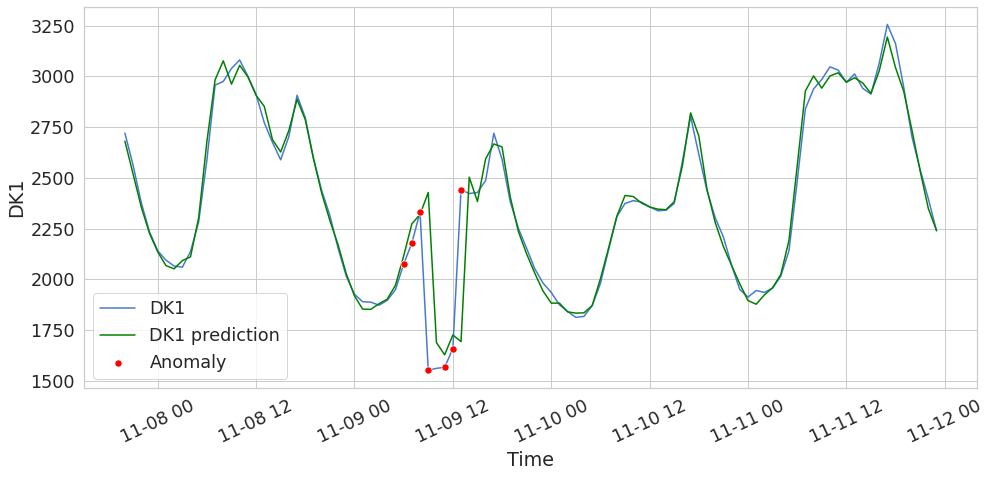

In [67]:
START_STEP = 0
END_STEP = 100

data = validation_data[START_STEP:END_STEP].copy()
PlotAnomalies(data, predicted_data[START_STEP:END_STEP], anomalies[anomalies["Time"].isin(data["Time"])])


**Add fake anomalies to the validation data and show the loss when predicting**

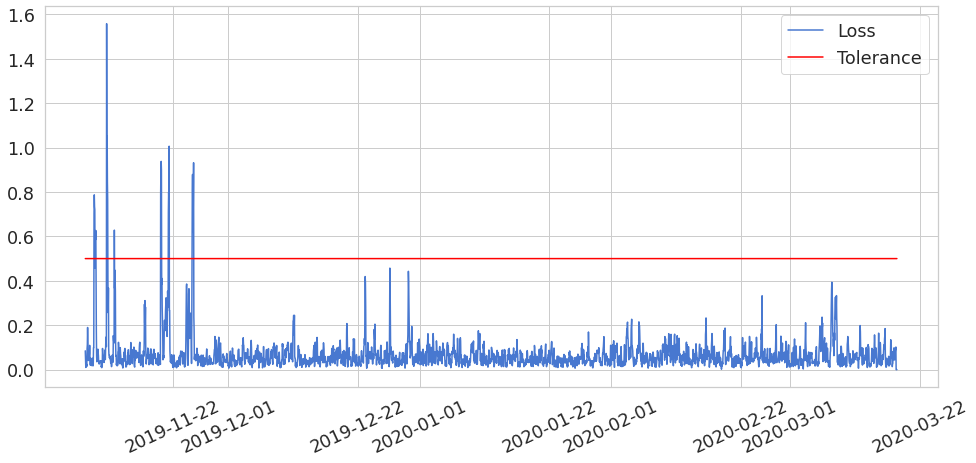

In [68]:
def AddFakeAnomalies(data):
    column = data.columns.get_loc(TRAIN_ON_COLUMNS[0])
    data.iloc[90, column] = 1000  # add one peak low value
    data.iloc[120, column] = 4000  # add one peak high value
    for i in range(0, 30):
        data.iloc[300 + i, column] -= 1000  # shift 30 consecutive steps down by 1000
    val = data.iloc[394, column]
    for i in range(0, 30):
        data.iloc[395 + i, column] = val  # copy a value for the next 30 consecutive steps


_, validation_data = SplitData()
AddFakeAnomalies(validation_data)

X_data, _ = ScaleData(validation_data[TRAIN_ON_COLUMNS], scaler, False)
validation_data = validation_data[PAST_STEP_COUNT:]

predicted_data, loss = PredictData(X_data, model, scaler)

anomalies = PlotLoss(validation_data, loss)


**Show the actual and predicted validation data with both fake and real anomalies**

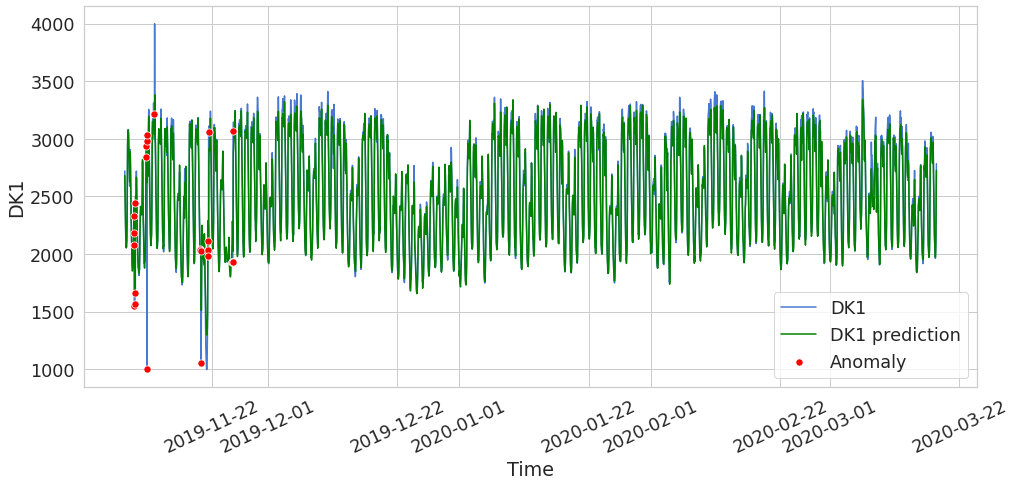

In [69]:
PlotAnomalies(validation_data, predicted_data, anomalies)

**Show the actual and predicted validation data with both fake and real anomalies**

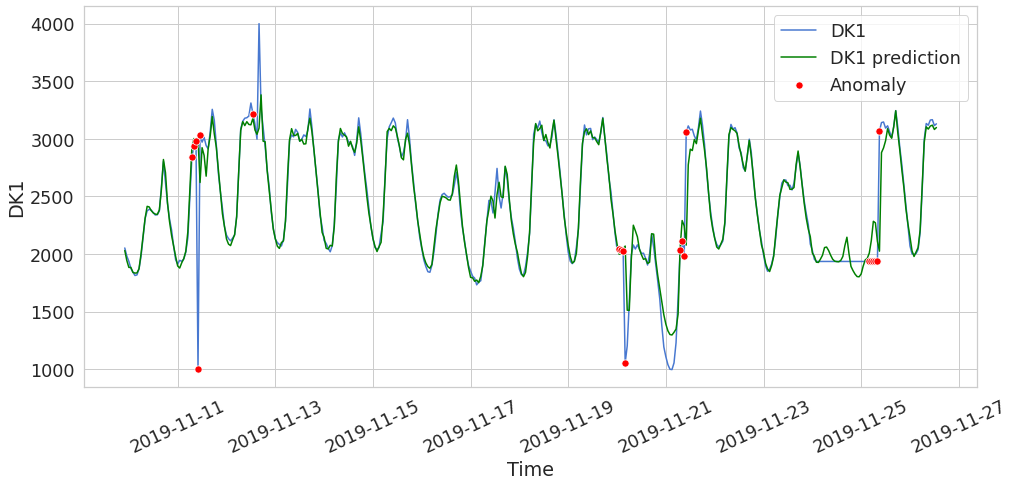

In [70]:
START_STEP = 50
END_STEP = 450

data = validation_data[START_STEP:END_STEP]
PlotAnomalies(data, predicted_data[START_STEP:END_STEP], anomalies[anomalies["Time"].isin(data["Time"])])